# ** Intel Image Classication **

We'll work with the [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification/version/2) from Kaggle.

This is image data of natural scenes around the world. It contains around 25k images of size 150x150 distributed under 6 categories.
The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [1]:
import os
import pathlib

from tqdm import tqdm
import itertools 
import cv2          

import numpy as np            
from sklearn.metrics import confusion_matrix    
from sklearn.utils import shuffle 
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sn; sn.set(font_scale=1.4)

import tensorflow as tf 
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, LeakyReLU, Dropout, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.python.ops.gen_math_ops import arg_max
from keras.preprocessing.image import ImageDataGenerator

In [2]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(10)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.xlabel("epochs")
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower left')
  plt.xlabel("epochs")
  plt.title('Training and Validation Loss')
  plt.show()

In [3]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [4]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [5]:
def print_mislabeled_images(class_names, test_data, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_data[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[mislabeled_labels[i]])
    plt.show()

In [6]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  
  # Create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Set labels to be classes
  if classes!=[]:
    labels = classes
  else: 
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted Label",
        ylabel="True Label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)

In [7]:
# Set the random seed
tf.random.set_seed(42)

# Import and preprocess the data

## Import the data

**Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cells above.

In [8]:
! mkdir ~/.kaggle # create the .kaggle folder in the root directory
! echo '{"username":"panagiotis427","key":"62e7ce1d44b49db295f005495a3e0ebc"}' > ~/.kaggle/kaggle.json # write kaggle API credentials to kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # set permissions
! pip install kaggle # install the kaggle library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
! kaggle datasets download -d puneet6060/intel-image-classification -p /content/kaggle/

 99% 343M/346M [00:09<00:00, 35.9MB/s]
100% 346M/346M [00:09<00:00, 39.4MB/s]


In [10]:
%cd kaggle
! unzip intel-image-classification

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/769

## Overview the data structure

`ls` stands for list.

In [11]:
!ls 

intel-image-classification.zip	seg_pred  seg_test  seg_train


In [12]:
!ls seg_train/seg_train

buildings  forest  glacier  mountain  sea  street


In [13]:
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

In [14]:
# Walk through train directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 6 directories and 0 images in 'seg_train/seg_train'.
There are 0 directories and 2271 images in 'seg_train/seg_train/forest'.
There are 0 directories and 2382 images in 'seg_train/seg_train/street'.
There are 0 directories and 2274 images in 'seg_train/seg_train/sea'.
There are 0 directories and 2191 images in 'seg_train/seg_train/buildings'.
There are 0 directories and 2404 images in 'seg_train/seg_train/glacier'.
There are 0 directories and 2512 images in 'seg_train/seg_train/mountain'.


In [15]:
# Another way to find out how many images are in a file
num_specific_class_train = len(os.listdir(train_dir))
num_specific_class_train

6

In [16]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [17]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (96, 96)
INPUT_TENSOR = (96, 96, 3)

## Load the data

In [18]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to test how accurately the network learned to classify images.
    """
    
    datasets = [train_dir, test_dir]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        images = images / 255.0

        output.append((images, labels))

    return output

In [19]:
(train_data, train_labels), (test_data, test_labels) = load_data()

Loading seg_train/seg_train


100%|██████████| 2512/2512 [00:03<00:00, 690.75it/s]


Loading seg_test/seg_test


100%|██████████| 525/525 [00:00<00:00, 772.59it/s]


In [20]:
tf.random.set_seed(42)
train_data, train_labels = shuffle(train_data, train_labels, random_state=427)

## Analyze the data

In [21]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (96, 96)


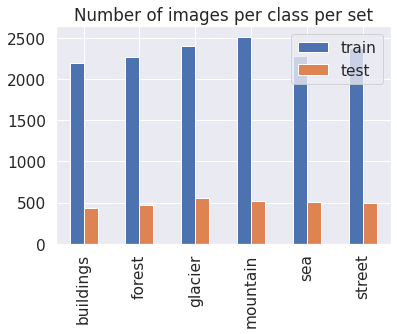

In [22]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.title("Number of images per class per set")
plt.show()

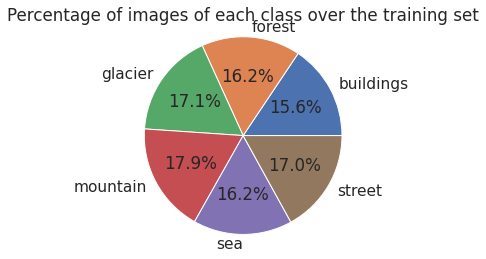

In [23]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0), 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percentage of images of each class over the training set')
plt.show()

## Visualize the data 

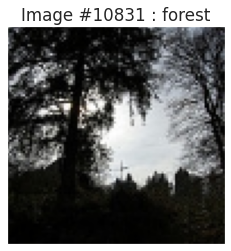

In [24]:
display_random_image(class_names, train_data, train_labels)

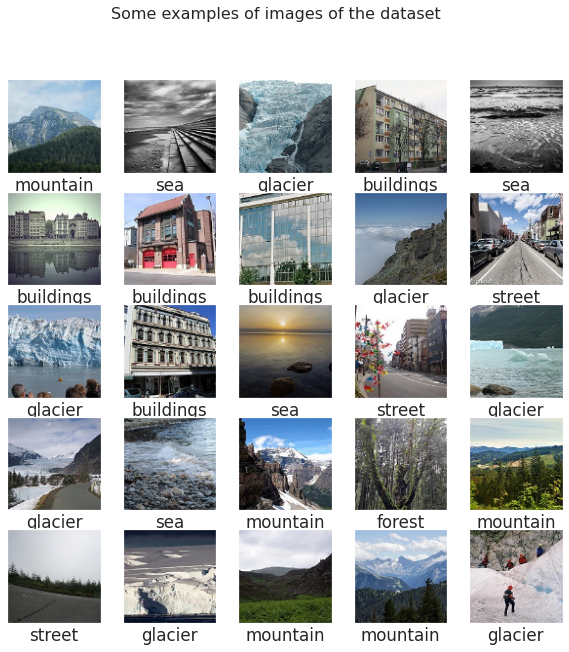

In [25]:
display_examples(class_names, train_data, train_labels)

# Create, train, evaluate basic models

## FCNN (model_FC)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_FC = Sequential([
  Flatten(),
  Dense(100),
  Activation('relu'),
  Dense(50),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_FC.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_FC = model_FC.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 4s 7ms/step - loss: 1.8987 - accuracy: 0.4108 - val_loss: 1.4104 - val_accuracy: 0.4314
Epoch 2/10
351/351 [==============================] - 3s 8ms/step - loss: 1.4307 - accuracy: 0.4731 - val_loss: 1.4002 - val_accuracy: 0.4813
Epoch 3/10
351/351 [==============================] - 3s 9ms/step - loss: 1.2870 - accuracy: 0.5098 - val_loss: 1.3628 - val_accuracy: 0.4824
Epoch 4/10
351/351 [==============================] - 3s 9ms/step - loss: 1.2202 - accuracy: 0.5326 - val_loss: 1.2445 - val_accuracy: 0.5362
Epoch 5/10
351/351 [==============================] - 3s 8ms/step - loss: 1.1899 - accuracy: 0.5416 - val_loss: 1.2755 - val_accuracy: 0.5102
Epoch 6/10
351/351 [==============================] - 3s 8ms/step - loss: 1.1774 - accuracy: 0.5501 - val_loss: 1.1743 - val_accuracy: 0.5604
Epoch 7/10
351/351 [==============================] - 3s 8ms/step - loss: 1.1321 - accuracy: 0.5675 - val_loss: 1.2216 - val_accuracy: 0.5369
Epoch 

In [ ]:
model_FC.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 27648)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               2764900   
                                                                 
 activation_38 (Activation)  (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 50)                5050      
                                                                 
 activation_39 (Activation)  (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 6)                 306       
                                                                 
 activation_40 (Activation)  (None, 6)                

In [ ]:
plot_accuracy_loss(history_FC)

## CNN (model_C)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_C = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_C.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_C = model_C.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 5s 11ms/step - loss: 0.9908 - accuracy: 0.6149 - val_loss: 0.7976 - val_accuracy: 0.7032
Epoch 2/10
351/351 [==============================] - 3s 8ms/step - loss: 0.6991 - accuracy: 0.7447 - val_loss: 0.5924 - val_accuracy: 0.7841
Epoch 3/10
351/351 [==============================] - 3s 9ms/step - loss: 0.5519 - accuracy: 0.7997 - val_loss: 0.5753 - val_accuracy: 0.7930
Epoch 4/10
351/351 [==============================] - 3s 8ms/step - loss: 0.4536 - accuracy: 0.8349 - val_loss: 0.5703 - val_accuracy: 0.8073
Epoch 5/10
351/351 [==============================] - 3s 9ms/step - loss: 0.3659 - accuracy: 0.8703 - val_loss: 0.5454 - val_accuracy: 0.8108
Epoch 6/10
351/351 [==============================] - 3s 8ms/step - loss: 0.2680 - accuracy: 0.9099 - val_loss: 0.6499 - val_accuracy: 0.7937
Epoch 7/10
351/351 [==============================] - 3s 9ms/step - loss: 0.2067 - accuracy: 0.9294 - val_loss: 0.6521 - val_accuracy: 0.8048
Epoch

In [ ]:
model_C.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 activation_41 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 activation_42 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                 

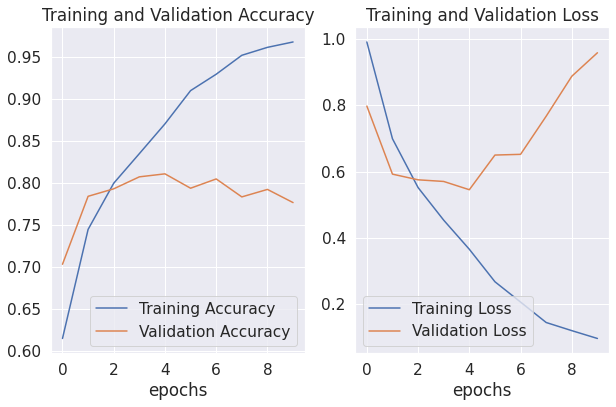

In [ ]:
plot_accuracy_loss(history_C)

## First results' and errors' analysis

In [ ]:
test_loss_FC = model_FC.evaluate(test_data, test_labels)

94/94 [==============================] - 0s 3ms/step - loss: 1.2738 - accuracy: 0.5240


In [ ]:
test_loss_C = model_C.evaluate(test_data, test_labels)

94/94 [==============================] - 0s 5ms/step - loss: 1.0408 - accuracy: 0.7540


94/94 [==============================] - 0s 3ms/step


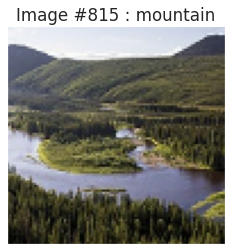

In [ ]:
# Using CNN for predictions

predictions = model_C.predict(test_data)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_data, pred_labels)

In [ ]:
print_mislabeled_images(class_names, test_data, test_labels, pred_labels)

In [ ]:
make_confusion_matrix(y_true=test_labels, y_pred=pred_labels, classes=class_names, figsize=(10, 10), text_size=10)

<ipython-input-66-7aca80be51b6>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if classes!=[]:


# Experimenting vol.1 based on model_C

## Increasing number of parameters (model_1)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_1 = Sequential([
  Conv2D(32, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_1 = model_1.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 7s 14ms/step - loss: 0.9631 - accuracy: 0.6309 - val_loss: 0.7789 - val_accuracy: 0.7097
Epoch 2/10
351/351 [==============================] - 4s 12ms/step - loss: 0.6610 - accuracy: 0.7567 - val_loss: 0.5751 - val_accuracy: 0.8044
Epoch 3/10
351/351 [==============================] - 4s 12ms/step - loss: 0.5217 - accuracy: 0.8097 - val_loss: 0.5711 - val_accuracy: 0.8005
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.4121 - accuracy: 0.8504 - val_loss: 0.5620 - val_accuracy: 0.8126
Epoch 5/10
351/351 [==============================] - 5s 16ms/step - loss: 0.3063 - accuracy: 0.8883 - val_loss: 0.5854 - val_accuracy: 0.8147
Epoch 6/10
351/351 [==============================] - 5s 14ms/step - loss: 0.2152 - accuracy: 0.9251 - val_loss: 0.7214 - val_accuracy: 0.7980
Epoch 7/10
351/351 [==============================] - 4s 12ms/step - loss: 0.1428 - accuracy: 0.9518 - val_loss: 0.7996 - val_accuracy: 0.8119

In [ ]:
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 activation_46 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 activation_47 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                 

In [ ]:
plot_accuracy_loss(history_1)

## Adding 1 convolutional and 1 dense layer (model_2)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_2 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_2 = model_2.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 6s 11ms/step - loss: 1.0490 - accuracy: 0.5916 - val_loss: 0.8541 - val_accuracy: 0.6794
Epoch 2/10
351/351 [==============================] - 3s 9ms/step - loss: 0.7697 - accuracy: 0.7091 - val_loss: 0.6480 - val_accuracy: 0.7588
Epoch 3/10
351/351 [==============================] - 3s 10ms/step - loss: 0.6205 - accuracy: 0.7681 - val_loss: 0.5931 - val_accuracy: 0.7873
Epoch 4/10
351/351 [==============================] - 3s 9ms/step - loss: 0.5216 - accuracy: 0.8100 - val_loss: 0.5158 - val_accuracy: 0.8169
Epoch 5/10
351/351 [==============================] - 3s 9ms/step - loss: 0.4495 - accuracy: 0.8378 - val_loss: 0.5127 - val_accuracy: 0.8212
Epoch 6/10
351/351 [==============================] - 3s 9ms/step - loss: 0.3644 - accuracy: 0.8665 - val_loss: 0.5405 - val_accuracy: 0.8233
Epoch 7/10
351/351 [==============================] - 3s 10ms/step - loss: 0.3149 - accuracy: 0.8832 - val_loss: 0.5385 - val_accuracy: 0.8190
Epo

In [ ]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 activation_51 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 activation_52 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                

In [ ]:
plot_accuracy_loss(history_2)

## Adding 2 convolutional and 2 dense layers (model_3)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_3 = Sequential([
  Conv2D(8, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(60),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 7s 11ms/step - loss: 1.1211 - accuracy: 0.5611 - val_loss: 0.8918 - val_accuracy: 0.6473
Epoch 2/10
351/351 [==============================] - 3s 9ms/step - loss: 0.8384 - accuracy: 0.6785 - val_loss: 0.7234 - val_accuracy: 0.7307
Epoch 3/10
351/351 [==============================] - 3s 8ms/step - loss: 0.7242 - accuracy: 0.7302 - val_loss: 0.6777 - val_accuracy: 0.7524
Epoch 4/10
351/351 [==============================] - 3s 10ms/step - loss: 0.6460 - accuracy: 0.7611 - val_loss: 0.6126 - val_accuracy: 0.7763
Epoch 5/10
351/351 [==============================] - 3s 8ms/step - loss: 0.5767 - accuracy: 0.7899 - val_loss: 0.5939 - val_accuracy: 0.7862
Epoch 6/10
351/351 [==============================] - 3s 9ms/step - loss: 0.5214 - accuracy: 0.8077 - val_loss: 0.5591 - val_accuracy: 0.8041
Epoch 7/10
351/351 [==============================] - 3s 8ms/step - loss: 0.4630 - accuracy: 0.8375 - val_loss: 0.5377 - val_accuracy: 0.8101
Epoc

In [ ]:
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 96, 96, 8)         224       
                                                                 
 activation_58 (Activation)  (None, 96, 96, 8)         0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 48, 48, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 16)        1168      
                                                                 
 activation_59 (Activation)  (None, 48, 48, 16)        0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                

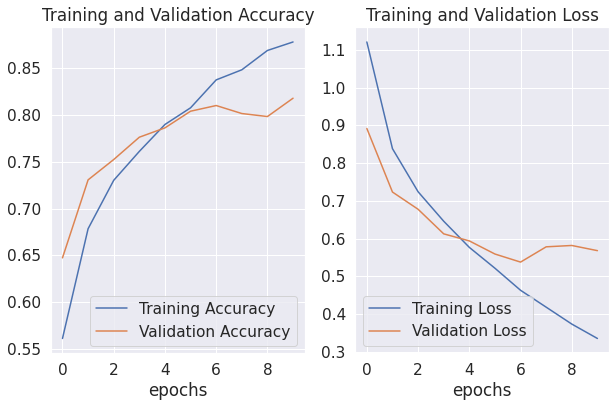

In [ ]:
plot_accuracy_loss(history_3)

## Decreasing number of parameters (model_4)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_4 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(60),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_4 = model_4.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 5s 10ms/step - loss: 1.0519 - accuracy: 0.5924 - val_loss: 0.7820 - val_accuracy: 0.7054
Epoch 2/10
351/351 [==============================] - 3s 8ms/step - loss: 0.7538 - accuracy: 0.7279 - val_loss: 0.6832 - val_accuracy: 0.7524
Epoch 3/10
351/351 [==============================] - 3s 8ms/step - loss: 0.6367 - accuracy: 0.7664 - val_loss: 0.6189 - val_accuracy: 0.7848
Epoch 4/10
351/351 [==============================] - 3s 8ms/step - loss: 0.5710 - accuracy: 0.7969 - val_loss: 0.5474 - val_accuracy: 0.8026
Epoch 5/10
351/351 [==============================] - 3s 7ms/step - loss: 0.5234 - accuracy: 0.8130 - val_loss: 0.5517 - val_accuracy: 0.8055
Epoch 6/10
351/351 [==============================] - 3s 9ms/step - loss: 0.4579 - accuracy: 0.8369 - val_loss: 0.5522 - val_accuracy: 0.8016
Epoch 7/10
351/351 [==============================] - 3s 8ms/step - loss: 0.4205 - accuracy: 0.8513 - val_loss: 0.5118 - val_accuracy: 0.8204
Epoch

In [ ]:
model_4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 activation_67 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 activation_68 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                

In [ ]:
plot_accuracy_loss(history_4)

## Removing 1 convolutional layer (model_5)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_5 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_5 = model_5.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 5s 9ms/step - loss: 1.0317 - accuracy: 0.6103 - val_loss: 0.7422 - val_accuracy: 0.7285
Epoch 2/10
351/351 [==============================] - 3s 8ms/step - loss: 0.6831 - accuracy: 0.7510 - val_loss: 0.6874 - val_accuracy: 0.7471
Epoch 3/10
351/351 [==============================] - 3s 8ms/step - loss: 0.5391 - accuracy: 0.8021 - val_loss: 0.6247 - val_accuracy: 0.7866
Epoch 4/10
351/351 [==============================] - 3s 7ms/step - loss: 0.4006 - accuracy: 0.8610 - val_loss: 0.6013 - val_accuracy: 0.7966
Epoch 5/10
351/351 [==============================] - 3s 7ms/step - loss: 0.2917 - accuracy: 0.8980 - val_loss: 0.6270 - val_accuracy: 0.7805
Epoch 6/10
351/351 [==============================] - 3s 7ms/step - loss: 0.2003 - accuracy: 0.9328 - val_loss: 0.7614 - val_accuracy: 0.7805
Epoch 7/10
351/351 [==============================] - 3s 9ms/step - loss: 0.1422 - accuracy: 0.9568 - val_loss: 0.8697 - val_accuracy: 0.7759
Epoch 

In [ ]:
model_5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 activation_72 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 activation_73 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                

In [ ]:
plot_accuracy_loss(history_5)

## Comparing our models' accuracies so far vol.1

In [ ]:
mfc = max(history_FC.history['val_accuracy'])
mc = max(history_C.history['val_accuracy'])
m1 = max(history_1.history['val_accuracy'])
m2 = max(history_2.history['val_accuracy'])
m3 = max(history_3.history['val_accuracy'])
m4 = max(history_4.history['val_accuracy'])
m5 = max(history_5.history['val_accuracy'])

model_results_1 = [["model_FC", mfc],
                 ["model_C", mc],
                 ["model_1", m1],
                 ["model_2", m2],
                 ["model_3", m3],
                 ["model_4", m4],
                 ["model_5", m5]]

In [ ]:
# Let's compare our model's results using a pandas DataFrame
all_results_1 = pd.DataFrame(model_results_1, columns=["model", "val_accuracy"])
all_results_1

model  val_accuracy
0  model_FC      0.560385
1   model_C      0.810830
2   model_1      0.814749
3   model_2      0.829355
4   model_3      0.817955
5   model_4      0.822586
6   model_5      0.796580

# Experimenting vol. 2 based on model_2

## Changing activation function to LeakyReLU (model_6)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_6 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  LeakyReLU(alpha=0.2),
  Dense(120),
  LeakyReLU(alpha=0.2),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_6 = model_6.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 17s 14ms/step - loss: 1.0108 - accuracy: 0.6084 - val_loss: 0.7690 - val_accuracy: 0.7111
Epoch 2/10
351/351 [==============================] - 4s 10ms/step - loss: 0.6977 - accuracy: 0.7471 - val_loss: 0.5937 - val_accuracy: 0.7916
Epoch 3/10
351/351 [==============================] - 4s 10ms/step - loss: 0.5779 - accuracy: 0.7918 - val_loss: 0.5850 - val_accuracy: 0.7866
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.4769 - accuracy: 0.8283 - val_loss: 0.5112 - val_accuracy: 0.8258
Epoch 5/10
351/351 [==============================] - 4s 11ms/step - loss: 0.3903 - accuracy: 0.8586 - val_loss: 0.5510 - val_accuracy: 0.8126
Epoch 6/10
351/351 [==============================] - 4s 10ms/step - loss: 0.3189 - accuracy: 0.8890 - val_loss: 0.5925 - val_accuracy: 0.8115
Epoch 7/10
351/351 [==============================] - 4s 11ms/step - loss: 0.2411 - accuracy: 0.9136 - val_loss: 0.6450 - val_accuracy: 0.807

In [ ]:
plot_accuracy_loss(history_6)

## Changing optimizer to SGD (model_7)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_7 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_7.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

In [ ]:
history_7 = model_7.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 5s 11ms/step - loss: 1.5728 - accuracy: 0.3715 - val_loss: 1.2876 - val_accuracy: 0.5162
Epoch 2/10
351/351 [==============================] - 3s 9ms/step - loss: 1.1923 - accuracy: 0.5383 - val_loss: 1.1040 - val_accuracy: 0.5775
Epoch 3/10
351/351 [==============================] - 4s 11ms/step - loss: 1.0531 - accuracy: 0.5831 - val_loss: 0.9806 - val_accuracy: 0.6252
Epoch 4/10
351/351 [==============================] - 3s 10ms/step - loss: 0.9748 - accuracy: 0.6170 - val_loss: 0.9880 - val_accuracy: 0.5964
Epoch 5/10
351/351 [==============================] - 3s 9ms/step - loss: 0.9328 - accuracy: 0.6345 - val_loss: 0.8622 - val_accuracy: 0.6665
Epoch 6/10
351/351 [==============================] - 3s 9ms/step - loss: 0.8882 - accuracy: 0.6584 - val_loss: 0.8601 - val_accuracy: 0.6705
Epoch 7/10
351/351 [==============================] - 3s 10ms/step - loss: 0.8595 - accuracy: 0.6684 - val_loss: 0.8207 - val_accuracy: 0.6797
Ep

In [ ]:
plot_accuracy_loss(history_7)

## Changing optimizer to RMSprop (model_8)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_8 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_8.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=["accuracy"])

In [ ]:
history_8 = model_8.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 6s 11ms/step - loss: 1.1715 - accuracy: 0.5392 - val_loss: 1.0118 - val_accuracy: 0.6138
Epoch 2/10
351/351 [==============================] - 3s 10ms/step - loss: 0.8427 - accuracy: 0.6765 - val_loss: 0.7651 - val_accuracy: 0.7189
Epoch 3/10
351/351 [==============================] - 3s 10ms/step - loss: 0.7077 - accuracy: 0.7356 - val_loss: 0.7154 - val_accuracy: 0.7200
Epoch 4/10
351/351 [==============================] - 4s 11ms/step - loss: 0.6101 - accuracy: 0.7738 - val_loss: 0.6017 - val_accuracy: 0.7784
Epoch 5/10
351/351 [==============================] - 3s 9ms/step - loss: 0.5172 - accuracy: 0.8125 - val_loss: 0.6076 - val_accuracy: 0.7905
Epoch 6/10
351/351 [==============================] - 3s 10ms/step - loss: 0.4486 - accuracy: 0.8378 - val_loss: 0.5495 - val_accuracy: 0.8119
Epoch 7/10
351/351 [==============================] - 3s 9ms/step - loss: 0.3852 - accuracy: 0.8589 - val_loss: 0.6265 - val_accuracy: 0.8048
E

In [ ]:
plot_accuracy_loss(history_8)

## Plotting loss over learning rate (model_9)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_9 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_9.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create the learning rate callback
lr_scheduler_9 = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20))

In [ ]:
history_9 = model_9.fit(train_data, train_labels, batch_size=32, epochs=80, validation_split = 0.2, callbacks=[lr_scheduler_9])

Epoch 1/80
351/351 [==============================] - 6s 11ms/step - loss: 1.7107 - accuracy: 0.3574 - val_loss: 1.5272 - val_accuracy: 0.4874 - lr: 1.0000e-05
Epoch 2/80
351/351 [==============================] - 4s 12ms/step - loss: 1.2892 - accuracy: 0.5285 - val_loss: 1.1407 - val_accuracy: 0.5771 - lr: 1.1220e-05
Epoch 3/80
351/351 [==============================] - 6s 17ms/step - loss: 1.1121 - accuracy: 0.5750 - val_loss: 1.0657 - val_accuracy: 0.5853 - lr: 1.2589e-05
Epoch 4/80
351/351 [==============================] - 5s 16ms/step - loss: 1.0525 - accuracy: 0.5970 - val_loss: 1.0204 - val_accuracy: 0.6088 - lr: 1.4125e-05
Epoch 5/80
351/351 [==============================] - 4s 12ms/step - loss: 1.0074 - accuracy: 0.6165 - val_loss: 0.9777 - val_accuracy: 0.6299 - lr: 1.5849e-05
Epoch 6/80
351/351 [==============================] - 3s 9ms/step - loss: 0.9596 - accuracy: 0.6339 - val_loss: 0.9309 - val_accuracy: 0.6423 - lr: 1.7783e-05
Epoch 7/80
351/351 [=====================

In [ ]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt

lrs = 1e-5 * (10**(tf.range(80)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_9.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate")

Text(0.5, 1.0, 'Finding the ideal learning rate')

In [ ]:
def plot_accuracy_loss_2(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(80)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.xlabel("epochs")
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.xlabel("epochs")
  plt.title('Training and Validation Loss')
  plt.show()

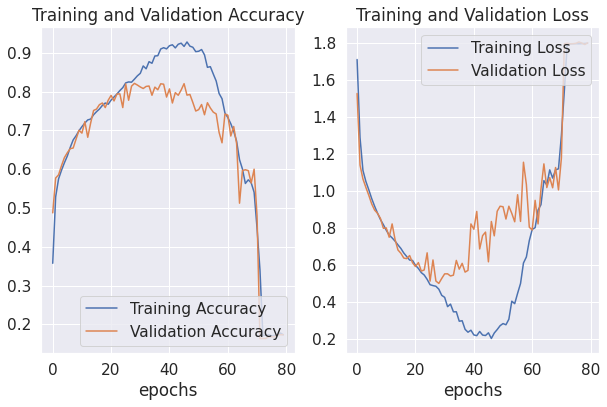

In [ ]:
plot_accuracy_loss_2(history_9)

## Changing learning rate to 6e-4 (model_10)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_10 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_10.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_10 = model_10.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 7s 13ms/step - loss: 1.0818 - accuracy: 0.5803 - val_loss: 0.7918 - val_accuracy: 0.6954
Epoch 2/10
351/351 [==============================] - 3s 9ms/step - loss: 0.7573 - accuracy: 0.7205 - val_loss: 0.6029 - val_accuracy: 0.7827
Epoch 3/10
351/351 [==============================] - 3s 10ms/step - loss: 0.6203 - accuracy: 0.7761 - val_loss: 0.5564 - val_accuracy: 0.8098
Epoch 4/10
351/351 [==============================] - 4s 10ms/step - loss: 0.5393 - accuracy: 0.8041 - val_loss: 0.5492 - val_accuracy: 0.8005
Epoch 5/10
351/351 [==============================] - 4s 10ms/step - loss: 0.4752 - accuracy: 0.8308 - val_loss: 0.5024 - val_accuracy: 0.8265
Epoch 6/10
351/351 [==============================] - 3s 9ms/step - loss: 0.4150 - accuracy: 0.8547 - val_loss: 0.5178 - val_accuracy: 0.8240
Epoch 7/10
351/351 [==============================] - 4s 10ms/step - loss: 0.3726 - accuracy: 0.8652 - val_loss: 0.4591 - val_accuracy: 0.8390
E

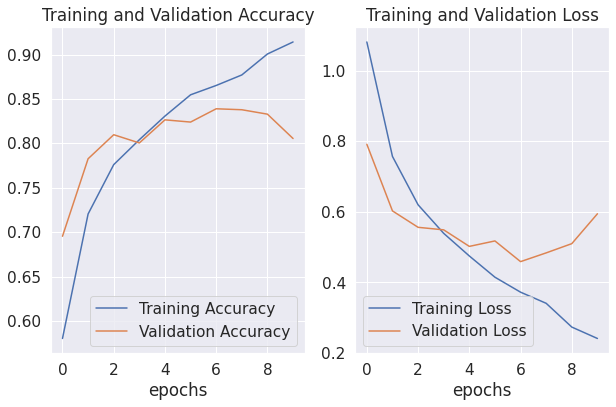

In [ ]:
plot_accuracy_loss(history_10)

## Comparing our models' accuracies so far vol.2

In [ ]:
m6 = max(history_6.history['val_accuracy'])
m7 = max(history_7.history['val_accuracy'])
m8 = max(history_8.history['val_accuracy'])
m10 = max(history_10.history['val_accuracy'])

model_results_2 = [["model_6", m6],
                 ["model_7", m7],
                 ["model_8", m8],
                 ["model_10", m10]]

In [ ]:
# Let's compare our model's results using a pandas DataFrame
all_results_2 = pd.DataFrame(model_results_2, columns=["model", "val_accuracy"])
all_results_2

model  val_accuracy
0   model_6      0.825793
1   model_7      0.729605
2   model_8      0.825793
3  model_10      0.838974

# Experimenting vol. 3 based on model_10

## BatchNormalization (model_11)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_11 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  BatchNormalization(),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  BatchNormalization(),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  BatchNormalization(),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  BatchNormalization(),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  BatchNormalization(),
  Dense(120),
  Activation('relu'),
  BatchNormalization(),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_11.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_11 = model_11.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 19s 15ms/step - loss: 0.8643 - accuracy: 0.6852 - val_loss: 2.4514 - val_accuracy: 0.3416
Epoch 2/10
351/351 [==============================] - 5s 14ms/step - loss: 0.5880 - accuracy: 0.7879 - val_loss: 0.6404 - val_accuracy: 0.7592
Epoch 3/10
351/351 [==============================] - 4s 12ms/step - loss: 0.4773 - accuracy: 0.8244 - val_loss: 0.6449 - val_accuracy: 0.7688
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.4069 - accuracy: 0.8553 - val_loss: 0.6100 - val_accuracy: 0.7866
Epoch 5/10
351/351 [==============================] - 5s 14ms/step - loss: 0.3294 - accuracy: 0.8838 - val_loss: 1.5054 - val_accuracy: 0.6071
Epoch 6/10
351/351 [==============================] - 4s 12ms/step - loss: 0.2654 - accuracy: 0.9065 - val_loss: 0.8909 - val_accuracy: 0.7382
Epoch 7/10
351/351 [==============================] - 4s 12ms/step - loss: 0.2205 - accuracy: 0.9214 - val_loss: 0.6069 - val_accuracy: 0.808

In [ ]:
model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 activation (Activation)     (None, 96, 96, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0

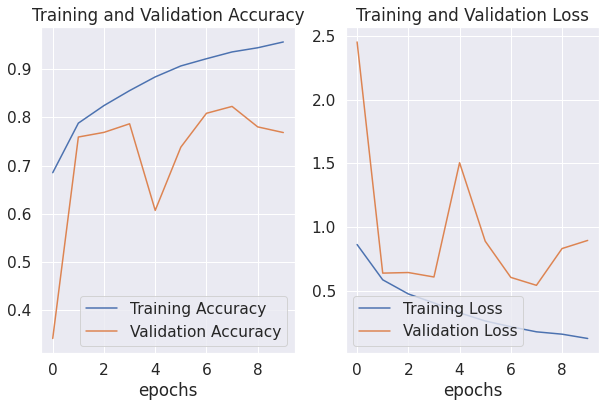

In [ ]:
plot_accuracy_loss(history_11)

## Data augmentation (model_12)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

data_augmentation = Sequential([
  RandomFlip("horizontal", input_shape=INPUT_TENSOR),
  RandomRotation(0.05),
])

#  RandomBrightness(0.1)
#  RandomContrast(0.1),
#  RandomZoom(0.05),

In [ ]:
def display_random_image_and_augmented_image(class_names, images, labels):
    """
        Display a random image and the respective augmented image from the images array and its correspond label from the labels array.
    """

    tf.random.set_seed(42)
    index = np.random.randint(images.shape[0])
    image = images[index]

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

    plt.figure()

    image = tf.cast(tf.expand_dims(image, 0), tf.float32)
    augmented_image = data_augmentation(image)[0]
    plt.imshow(augmented_image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Augmented Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

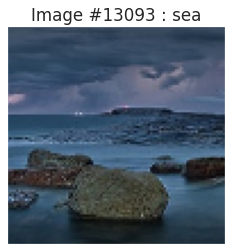

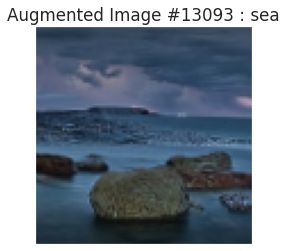

In [ ]:
display_random_image_and_augmented_image(class_names, train_data, train_labels)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_12 = Sequential([
  data_augmentation,
  Conv2D(16, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_12.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_12 = model_12.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10


351/351 [==============================] - 33s 82ms/step - loss: 1.0827 - accuracy: 0.5741 - val_loss: 0.9229 - val_accuracy: 0.6462
Epoch 2/10
351/351 [==============================] - 27s 77ms/step - loss: 0.8210 - accuracy: 0.6881 - val_loss: 0.7094 - val_accuracy: 0.7353
Epoch 3/10
351/351 [==============================] - 27s 77ms/step - loss: 0.7051 - accuracy: 0.7401 - val_loss: 0.7524 - val_accuracy: 0.7132
Epoch 4/10
351/351 [==============================] - 27s 76ms/step - loss: 0.6263 - accuracy: 0.7733 - val_loss: 0.6669 - val_accuracy: 0.7563
Epoch 5/10
351/351 [==============================] - 28s 80ms/step - loss: 0.5669 - accuracy: 0.7958 - val_loss: 0.5472 - val_accuracy: 0.7998
Epoch 6/10
351/351 [==============================] - 27s 77ms/step - loss: 0.5266 - accuracy: 0.8101 - val_loss: 0.5295 - val_accuracy: 0.8147
Epoch 7/10
351/351 [==============================] - 27s 78ms/step - loss: 0.4815 - accuracy: 0.8257 - val_loss: 0.5425 - val_accuracy: 0.8108
Epo

You can see each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

In [ ]:
model_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_7 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                      

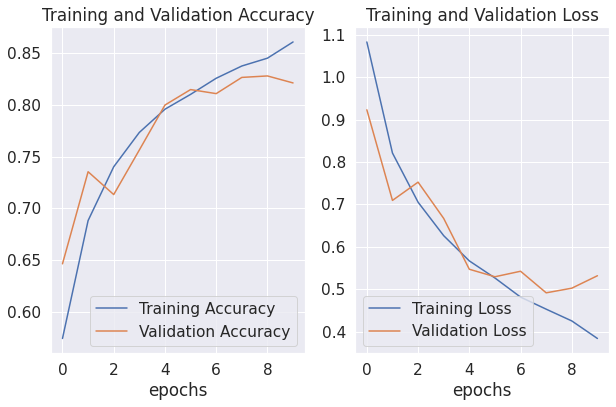

In [ ]:
plot_accuracy_loss(history_12)

That's looking much better, the loss curves are much closer to each other. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

## Dropout (model_13)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_13 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Dropout(0.25),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

# Compile the model
model_13.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [ ]:
history_13 = model_13.fit(train_data, train_labels, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
351/351 [==============================] - 7s 14ms/step - loss: 1.2031 - accuracy: 0.5162 - val_loss: 1.0512 - val_accuracy: 0.6142
Epoch 2/10
351/351 [==============================] - 4s 12ms/step - loss: 0.9101 - accuracy: 0.6516 - val_loss: 0.8777 - val_accuracy: 0.6662
Epoch 3/10
351/351 [==============================] - 4s 11ms/step - loss: 0.7649 - accuracy: 0.7138 - val_loss: 0.7694 - val_accuracy: 0.7389
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.6641 - accuracy: 0.7542 - val_loss: 0.6078 - val_accuracy: 0.7919
Epoch 5/10
351/351 [==============================] - 4s 11ms/step - loss: 0.6001 - accuracy: 0.7824 - val_loss: 0.5769 - val_accuracy: 0.7973
Epoch 6/10
351/351 [==============================] - 4s 11ms/step - loss: 0.5407 - accuracy: 0.8015 - val_loss: 0.6674 - val_accuracy: 0.7595
Epoch 7/10
351/351 [==============================] - 4s 13ms/step - loss: 0.5061 - accuracy: 0.8171 - val_loss: 0.5218 - val_accuracy: 0.8140

In [ ]:
model_13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_14 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_15 (Activation)  (None, 48, 48, 32)        0         
                                                      

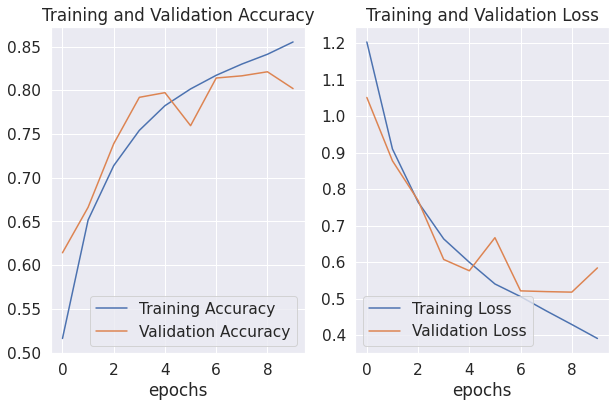

In [ ]:
plot_accuracy_loss(history_13)

## Comparing our models' accuracies so far vol.3

In [ ]:
test_loss_11 = model_11.evaluate(test_data, test_labels)

94/94 [==============================] - 1s 6ms/step - loss: 0.9733 - accuracy: 0.7370


In [ ]:
test_loss_12 = model_12.evaluate(test_data, test_labels)

94/94 [==============================] - 1s 5ms/step - loss: 0.5611 - accuracy: 0.8093


In [ ]:
test_loss_13 = model_13.evaluate(test_data, test_labels)

94/94 [==============================] - 0s 5ms/step - loss: 0.6196 - accuracy: 0.7873


In [ ]:
m11 = max(history_11.history['val_accuracy'])
m12 = max(history_12.history['val_accuracy'])
m13 = max(history_13.history['val_accuracy'])

model_results_3 = [["model_11", test_loss_11[1]],
                 ["model_12", test_loss_12[1]],
                 ["model_13", test_loss_13[1]]]

In [ ]:
# Let's compare our model's results using a pandas DataFrame
all_results_3 = pd.DataFrame(model_results_3, columns=["model", "test_accuracy"])
all_results_3

model  test_accuracy
0  model_11       0.737000
1  model_12       0.809333
2  model_13       0.787333

# Final model (model_14)

## Training for longer (more epochs)

In [26]:
# Set the random seed
tf.random.set_seed(42)

# Build the model
model_14 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

# Compile the model
model_14.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

In [27]:
# Fit the model
history_14 = model_14.fit(train_data, train_labels, batch_size=32, epochs=32, validation_split = 0.2, callbacks=[model_checkpoint_callback])

Epoch 1/32
351/351 [==============================] - ETA: 0s - loss: 1.0505 - accuracy: 0.6010
Epoch 1: val_accuracy improved from -inf to 0.67260, saving model to /tmp/checkpoint
351/351 [==============================] - 15s 12ms/step - loss: 1.0505 - accuracy: 0.6010 - val_loss: 0.8449 - val_accuracy: 0.6726
Epoch 2/32
351/351 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.7239
Epoch 2: val_accuracy improved from 0.67260 to 0.74136, saving model to /tmp/checkpoint
351/351 [==============================] - 3s 10ms/step - loss: 0.7429 - accuracy: 0.7239 - val_loss: 0.6777 - val_accuracy: 0.7414
Epoch 3/32
346/351 [============================>.] - ETA: 0s - loss: 0.6323 - accuracy: 0.7654
Epoch 3: val_accuracy improved from 0.74136 to 0.77841, saving model to /tmp/checkpoint
351/351 [==============================] - 4s 11ms/step - loss: 0.6320 - accuracy: 0.7657 - val_loss: 0.6072 - val_accuracy: 0.7784
Epoch 4/32
351/351 [==============================] - 

In [28]:
model_14.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 activation (Activation)     (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                    

In [29]:
# Let's check out another way of viewing our deep learning models
# See the inputs and outputs of each layer
plot_model(model_14, show_shapes=True)

In [30]:
def plot_accuracy_loss_3(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(32)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.xlabel("epochs")
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='lower left')
  plt.xlabel("epochs")
  plt.title('Training and Validation Loss')
  plt.show()

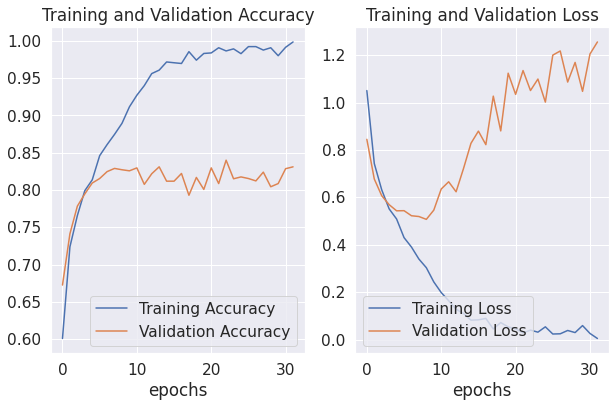

In [31]:
# Check out model's performance
plot_accuracy_loss_3(history_14)

## Results

In [32]:
# The model weights (that are considered the best) are loaded into the model.
model_14.load_weights(checkpoint_filepath)

In [33]:
test_loss_14 = model_14.evaluate(test_data, test_labels)

94/94 [==============================] - 1s 6ms/step - loss: 1.0334 - accuracy: 0.8340


94/94 [==============================] - 0s 4ms/step


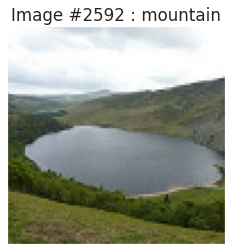

In [34]:
predictions = model_14.predict(test_data)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_data, pred_labels)

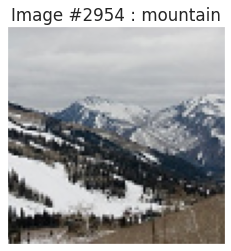

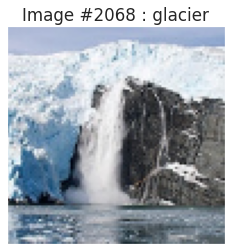

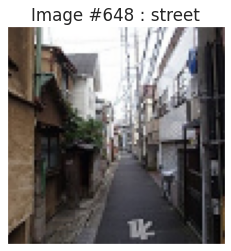

In [45]:
for i in range(3):
  display_random_image(class_names, test_data, pred_labels)

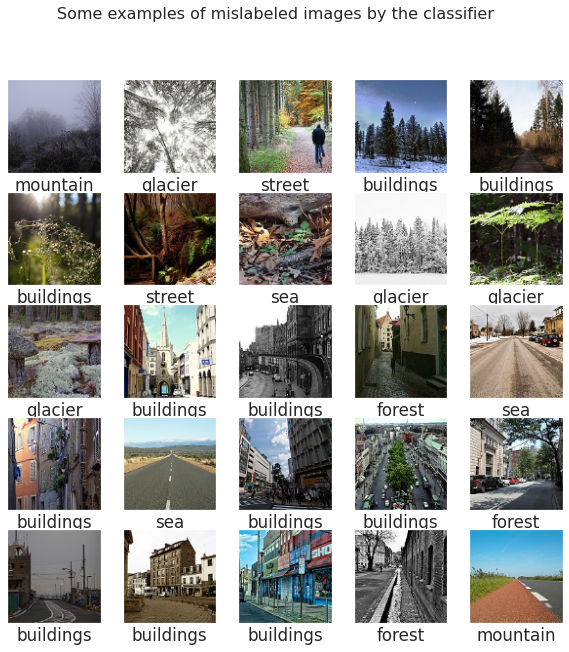

In [36]:
print_mislabeled_images(class_names, test_data, test_labels, pred_labels)

<ipython-input-6-7aca80be51b6>:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if classes!=[]:


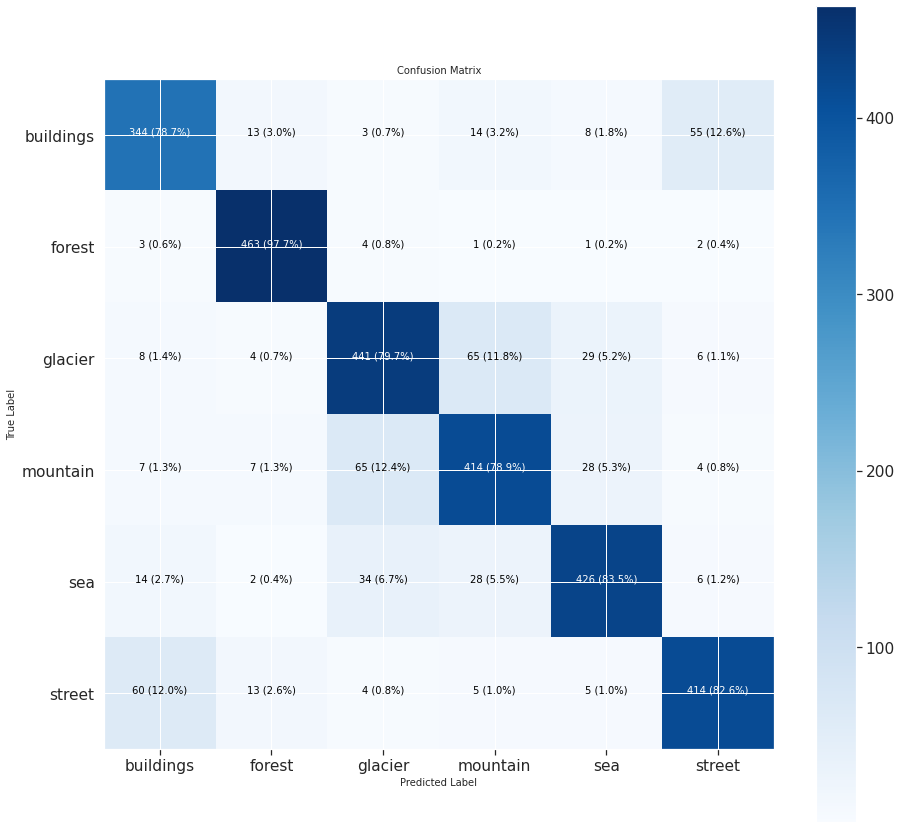

In [37]:
make_confusion_matrix(y_true=test_labels,
                      y_pred=pred_labels,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

# Saving and loading the best model

## Saving and loading weights of a model

In [38]:
# Save the weights
model_14.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
new_model = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(300),
  Activation('relu'),
  Dense(120),
  Activation('relu'),
  Dense(6),
  Activation('softmax')
])

new_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = 6e-4),
                metrics=["accuracy"])

# Restore the weights
new_model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss, acc = new_model.evaluate(test_data, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

94/94 - 1s - loss: 1.0334 - accuracy: 0.8340 - 911ms/epoch - 10ms/step
Restored model, accuracy: 83.40%


## Saving and loading a model in SavedModel format

In [39]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model_14.save('saved_model/my_model')

In [40]:
new_model_2 = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 activation (Activation)     (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                    

In [41]:
# Evaluate the restored model
loss, acc = new_model_2.evaluate(test_data, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model_2.predict(test_data).shape)

94/94 - 1s - loss: 1.0334 - accuracy: 0.8340 - 549ms/epoch - 6ms/step
Restored model, accuracy: 83.40%
94/94 [==============================] - 0s 4ms/step
(3000, 6)


## Saving and loading a model in HDF5 format

In [42]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_14.save('my_model.h5')

In [43]:
# Recreate the exact same model, including its weights and the optimizer
new_model_3 = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 activation (Activation)     (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                    

In [44]:
loss, acc = new_model_3.evaluate(test_data, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

94/94 - 1s - loss: 1.0334 - accuracy: 0.8340 - 549ms/epoch - 6ms/step
Restored model, accuracy: 83.40%
